# Latent Features for Recommendations
The goal of this problem is to implement the Stochastic Gradient Descent algorithm to build a Latent Factor Recommendation system. We can use it to recommend movies to users.

Suppose we are given a matrix R of recommendations. The element $R_{iu}$ of this matrix corresponds to the rating given by user $u$ to item $i$. The size of $R$ is $m × n$, where $m$ is the number of movies, and $n$ the numbers of users. Most of the elements of the matrix are unknown because each user can only rate a few movies. Our goal is to find two matrices $P$ and $Q$, such that $R ≃ QPT$. The dimensions of $Q$ are $m × k$, and the dimensions of $P$ are $n × k$. $k$ is a parameter of the algorithm.

We defined the error as 
$$ E = \sum\limits_{(i,u) \in \ ratings} (R_{iu} - q_i \cdot p^T_u)^2 + \lambda [\sum\limits_{u}\|p_u\|^{2}_{2} + \sum\limits_{i}\|q_i\|^{2}_{2}]$$

The $\sum\limits_{(i,u) \in \ ratings}$ means that we sum only on the pairs (user, item) for which the user has rated the item, i.e. the ($i, u$) entry of the matrix $R$ is known. $q_i$ denotes the $i^{th}$ row of the matrix $Q$ (corresponding to an item), and $p_u$ the $u^{th}$ row of the matrix $P$ (corresponding to a user $u$). $\lambda$ is the regularization parameter. $\|\cdot\|_{2}$ is the $L_2$ norm and $\|p_u\|^{2}_{2}$ is square of the $L_2$ norm, i.e., it is the sum of squares of elements of $p_u$.

## Part A
What is $\varepsilon_{iu}$? What are the update equations for $q_i$ and $p_u$ in the Stochastic Gradient Decent algorithm? Here, $\varepsilon_{iu}$ denotes the derivative of the error $E$ with respect to $R_{iu}$.

**Ans:**
$$\varepsilon_{iu} = R_{iu} - q_i \cdot p^T_u$$
$$q_i := q_i + \eta \ast (\varepsilon_{iu} \ast p_u - \lambda \ast q_i)$$
$$p_u := p_u + \eta \ast (\varepsilon_{iu} \ast q_i - \lambda \ast p_u)$$

## Part B
Implement the algorithm. Read each entry of the matrix $R$ from disk and update $\varepsilon_{iu}$, $q_i$ and $p_u$ for each entry. You have to read each element $R_{iu}$ at a time from disk and apply your update equations (to each element). Then, iterate until both $q_i$ and $p_u$ stop changing. Each iteration of the algorithm will read the whole file.

Choose $k$ = 20, $\lambda$ = 0.2 and number of iterations = 40. Find a good value for the learning rate $\eta$. Start with $\eta$ = 0.1. The error $E$ on the training set should be less than 83000 after 40 iterations.

Use the following files:

- **ratings.train.txt**: This is the matrix $R$. Each entry is made of a user id, a movie id, and a rating.
- **ratings.val.txt**: This is the test set. You will use it to evaluate your recommenda- tion system. It consists of entries of the matrix that were removed from the original dataset to create the training set.

Plot the value of the objective function $E$ on the training set as a function of the number of iterations. What value of $\eta$ did you find? 

**Ans**: $\eta$ = 0.03

In [10]:
%pylab inline
from __future__ import division
import numpy
import random
import math
import pylab

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
TRAIN_FILE = "ratings.train.txt"
TEST_FILE = "ratings.val.txt"

In [3]:
def get_matrix_dims(fileName):
    maxUserId = 0
    maxMovieId = 0
    data = open(fileName,"r")
    count = 0
    for line in data:
        count += 1
        [userId, movieId, rating] = line.split("\t")
        if int(movieId) > maxMovieId:
            maxMovieId  = int(movieId)

        if int(userId) > maxUserId: 
            maxUserId  = int(userId)
    data.close()
            
    return (maxUserId, maxMovieId)

In [4]:
def create_random_matrix(rows, cols):
    tmp = numpy.array([random.gauss(0, math.sqrt(5/cols)) for i in xrange(rows*cols)])
    tmp.shape = (rows,cols)
    return tmp

In [5]:
def total_error(P, Q, RFile, lam):
    data = open(RFile,"r")
    err = 0.0
    sumPL2Norm = sum([numpy.dot(i,i) for i in P])
    sumQL2Norm = sum([numpy.dot(i,i) for i in Q])
    
    for line in data:
        [u, i, r] = line.split("\t")
        u = int(u) - 1
        i = int(i) - 1
        r = float(r)
        err = err + math.pow((r - numpy.dot(Q[i,:], P[u,:])),2)
        
    err = err + lam * (sumPL2Norm + sumQL2Norm)
    
    return err

In [6]:
def t_error(P, Q, RFile):
    data = open(RFile,"r")
    err = 0.0
    
    for line in data:
        [u, i, r] = line.split("\t")
        u = int(u) - 1
        i = int(i) - 1
        r = float(r)
        err = err + math.pow((r - numpy.dot(Q[i,:], P[u,:])),2)
    
    return err

In [7]:
def stochastic_gradient_descent(P, Q, RFile, iter, lam, eta):
    print "Running SGD for %s iterations." % iter
    boom = False
    error = []
    for j in xrange(iter):
        if boom: break
        print "Iteration :",j, "...",
        data = open(RFile,"r")
        for line in data: 
            # Get u , m , r
            [u, i, r] = line.split("\t")
            # Numpy indexes array from 0
            u = int(u) - 1
            i = int(i) - 1
            r = float(r)

            if math.isnan(numpy.dot(Q[i,:], P[u,:])):
                errorTxt =  "(Iteration %s :Nan at u: %s i: %s r: %s )" \
                                % (j,u,i,r)
                boom = True
                raise Exception(errorTxt)
              
            # Calculate Error
            e = r - numpy.dot(Q[i,:], P[u,:]) 

            #Update q
            tmp_q = Q[i,:] + eta*(e*P[u,:] - lam*Q[i,:])

            #Update p
            tmp_p = P[u,:] + eta*(e*Q[i,:] - lam*P[u,:])
       
            Q[i,:] = tmp_q
            P[u,:] = tmp_p
           
        data.close() 
        print "done.",
        error.append(total_error(P,Q,RFile,lam))
        print "Error:[ %s ]" % (error[j])
    return P, Q, error

In [8]:
(u,m) = get_matrix_dims(TRAIN_FILE)

In [9]:
k = 20
iter = 40
lam = 0.2

eta = 0.03
P = create_random_matrix(u, k)
Q = create_random_matrix(m, k) 
P1, Q1, e1 = stochastic_gradient_descent(P,Q,TRAIN_FILE,iter,lam,eta)

Running SGD for 40 iterations.
Iteration : 0 ... done. Error:[ 95499.5874623 ]
Iteration : 1 ... done. Error:[ 86000.7261113 ]
Iteration : 2 ... done. Error:[ 84158.3631837 ]
Iteration : 3 ... done. Error:[ 83343.3261789 ]
Iteration : 4 ... done. Error:[ 82816.7717895 ]
Iteration : 5 ... done. Error:[ 82425.4314979 ]
Iteration : 6 ... done. Error:[ 82120.1133277 ]
Iteration : 7 ... done. Error:[ 81875.0196835 ]
Iteration : 8 ... done. Error:[ 81672.5153525 ]
Iteration : 9 ... done. Error:[ 81499.9223149 ]
Iteration : 10 ... done. Error:[ 81348.2929653 ]
Iteration : 11 ... done. Error:[ 81211.5068255 ]
Iteration : 12 ... done. Error:[ 81085.5182818 ]
Iteration : 13 ... done. Error:[ 80967.7549726 ]
Iteration : 14 ... done. Error:[ 80856.6555789 ]
Iteration : 15 ... done. Error:[ 80751.3241896 ]
Iteration : 16 ... done. Error:[ 80651.2779852 ]
Iteration : 17 ... done. Error:[ 80556.2686128 ]
Iteration : 18 ... done. Error:[ 80466.1612168 ]
Iteration : 19 ... done. Error:[ 80380.8577025 ]

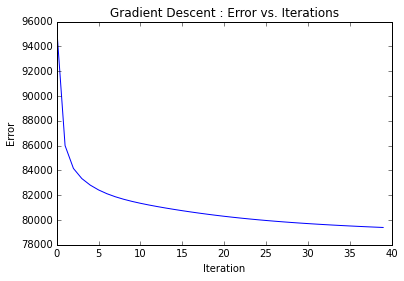

In [11]:
f0 = pylab.figure()
p1 = f0.add_subplot(111)
p1.plot([i for i in xrange(iter)],e1) 
p1.set_xlabel("Iteration")
p1.set_ylabel("Error")
p1.set_title("Gradient Descent : Error vs. Iterations")

## Part C
We define the training error as:
$$E_{tr} = \sum\limits_{(i,u) \in \ ratings} (R_{iu} - q_i \cdot p^T_u)^2$$

and the test error as:
$$E_{te} = \sum\limits_{(i,u) \in \ test ratings} (R_{iu} - q_i \cdot p^T_u)^2

Note that these equations do not include the regularization penalty that $E$ had from parts a and b. Plot $E_{te}$ and $E_{tr}$ as a function of $k  \in {1,2,...10}$ for the following values of $\lambda$:

- $\lambda$ = 0.0 (Part C.i)
- $\lambda$ = 0.2 (Part C.ii)

For $\eta$ use the value found in Part B. Based on the output, identify the valid statements.

**Ans:**

- Regularization decreases the test error for $k \ge$ 5
- Regularization increases the training error for all (or almost all) $k$
- Regularization decreases overfitting

## Part C.i

In [12]:
K = [i+1 for i in xrange(10)]

e_tot = [0 for i in K]
e_trn = [0 for i in K]
e_tst = [0 for i in K]
count = 0
eta = 0.03
lam = 0.0

In [13]:
for j in K:
    print "k = ",j
    P = create_random_matrix(u, j)
    Q = create_random_matrix(m, j)     
    X, Y, E = stochastic_gradient_descent(P,Q,TRAIN_FILE,iter,lam,eta)
    e_tot[count] = E.pop()
    e_trn[count]= t_error(X,Y,TRAIN_FILE)
    e_tst[count]= t_error(X,Y,TEST_FILE)
    print "Error[ Total :%s Training: %s Test: %s]" % \
                (e_tot[count],e_trn[count],e_tst[count])
    count = count + 1

k =  1
Running SGD for 40 iterations.
Iteration : 0 ... done. Error:[ 136759.455271 ]
Iteration : 1 ... done. Error:[ 96573.6092883 ]
Iteration : 2 ... done. Error:[ 90072.7930637 ]
Iteration : 3 ... done. Error:[ 87573.049329 ]
Iteration : 4 ... done. Error:[ 86325.2648696 ]
Iteration : 5 ... done. Error:[ 85613.3865923 ]
Iteration : 6 ... done. Error:[ 85170.2056962 ]
Iteration : 7 ... done. Error:[ 84875.4234431 ]
Iteration : 8 ... done. Error:[ 84668.3684783 ]
Iteration : 9 ... done. Error:[ 84516.1458324 ]
Iteration : 10 ... done. Error:[ 84399.9804438 ]
Iteration : 11 ... done. Error:[ 84308.6778821 ]
Iteration : 12 ... done. Error:[ 84235.2711301 ]
Iteration : 13 ... done. Error:[ 84175.2287853 ]
Iteration : 14 ... done. Error:[ 84125.4706226 ]
Iteration : 15 ... done. Error:[ 84083.8137734 ]
Iteration : 16 ... done. Error:[ 84048.6532935 ]
Iteration : 17 ... done. Error:[ 84018.7724987 ]
Iteration : 18 ... done. Error:[ 83993.226447 ]
Iteration : 19 ... done. Error:[ 83971.2675

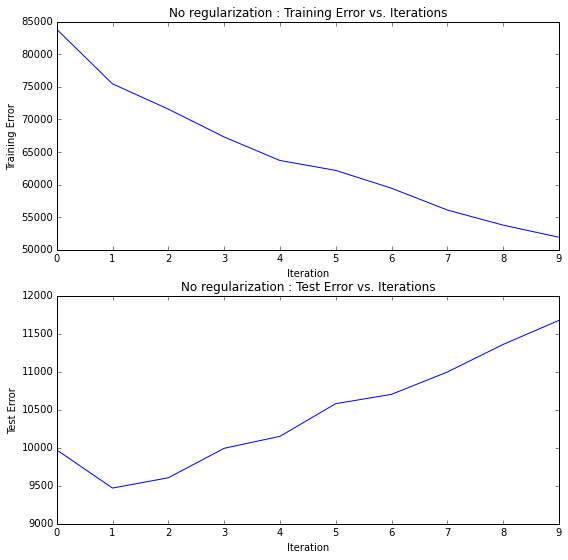

In [18]:
x = pylab.arange(0,len(K))

f1 = pylab.figure(figsize=(9,9))
p1 = f1.add_subplot(211)
p1.plot(x, e_trn)
p1.set_xlabel("Iteration")
p1.set_ylabel("Training Error")
p1.set_title("No regularization : Training Error vs. Iterations")

p2 = f1.add_subplot(212)
p2.plot(x, e_tst)
p2.set_xlabel("Iteration")
p2.set_ylabel("Test Error")
p2.set_title("No regularization : Test Error vs. Iterations")

## Part C.ii

In [19]:
e_tot_reg = [0 for i in K]
e_trn_reg = [0 for i in K]
e_tst_reg = [0 for i in K]
count = 0
eta = 0.03
lam = 0.2

In [20]:
for j in K:
    print "k = ",j
    P = create_random_matrix(u, j)
    Q = create_random_matrix(m, j)     
    X, Y, E = stochastic_gradient_descent(P,Q,TRAIN_FILE,iter,lam,eta)
    e_tot_reg[count] = E.pop()
    e_trn_reg[count]= t_error(X,Y,TRAIN_FILE)
    e_tst_reg[count]= t_error(X,Y,TEST_FILE)
    print "Error[ Total :%s Training: %s Test: %s]" % \
                (e_tot_reg[count],e_trn_reg[count],e_tst_reg[count])

    count = count + 1

k =  1
Running SGD for 40 iterations.
Iteration : 0 ... done. Error:[ 150693.672197 ]
Iteration : 1 ... done. Error:[ 101641.755951 ]
Iteration : 2 ... done. Error:[ 95079.6349238 ]
Iteration : 3 ... done. Error:[ 92583.7993911 ]
Iteration : 4 ... done. Error:[ 91335.8946456 ]
Iteration : 5 ... done. Error:[ 90619.5814071 ]
Iteration : 6 ... done. Error:[ 90172.4980125 ]
Iteration : 7 ... done. Error:[ 89877.7299946 ]
Iteration : 8 ... done. Error:[ 89675.83132 ]
Iteration : 9 ... done. Error:[ 89533.6077361 ]
Iteration : 10 ... done. Error:[ 89431.2146582 ]
Iteration : 11 ... done. Error:[ 89356.1707892 ]
Iteration : 12 ... done. Error:[ 89300.3188652 ]
Iteration : 13 ... done. Error:[ 89258.1684014 ]
Iteration : 14 ... done. Error:[ 89225.938433 ]
Iteration : 15 ... done. Error:[ 89200.9779743 ]
Iteration : 16 ... done. Error:[ 89181.4013604 ]
Iteration : 17 ... done. Error:[ 89165.8514182 ]
Iteration : 18 ... done. Error:[ 89153.3416282 ]
Iteration : 19 ... done. Error:[ 89143.14869

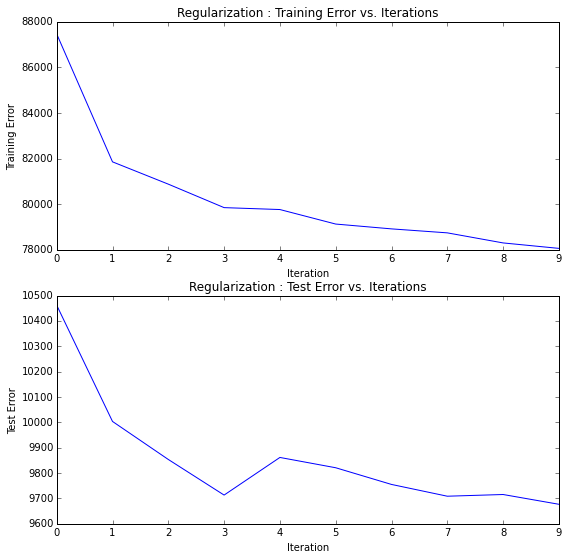

In [22]:
x = pylab.arange(0,len(K))

f2 = pylab.figure(figsize=(9,9))
p1 = f2.add_subplot(211)
p1.plot(x, e_trn_reg)
p1.set_xlabel("Iteration")
p1.set_ylabel("Training Error")
p1.set_title("Regularization : Training Error vs. Iterations")

p2 = f2.add_subplot(212)
p2.plot(x, e_tst_reg)
p2.set_xlabel("Iteration")
p2.set_ylabel("Test Error")
p2.set_title("Regularization : Test Error vs. Iterations")

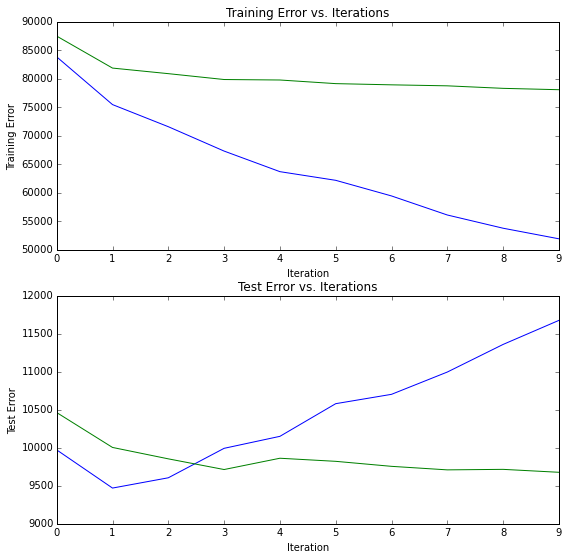

In [24]:
f3 = pylab.figure(figsize=(9,9))
p1 = f3.add_subplot(211)
p1.plot(x, e_trn)
p1.plot(x, e_trn_reg)
p1.set_xlabel("Iteration")
p1.set_ylabel("Training Error")
p1.set_title("Training Error vs. Iterations")

p2 = f3.add_subplot(212)
p2.plot(x, e_tst)
p2.plot(x, e_tst_reg)
p2.set_xlabel("Iteration")
p2.set_ylabel("Test Error")
p2.set_title("Test Error vs. Iterations")